In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
# nltk.download('punkt')
import re
from nltk.corpus import stopwords
# nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
# nltk.download('wordnet')

from sklearn.feature_extraction.text import TfidfVectorizer

from collections import Counter
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools

# pip install tabulate
from tabulate import tabulate

import seaborn as sns


### loading Data

In [2]:
Train_df = pd.read_csv("./BBC/BBC News Train.csv")
Train_df

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business
...,...,...,...
1485,857,double eviction from big brother model caprice...,entertainment
1486,325,dj double act revamp chart show dj duo jk and ...,entertainment
1487,1590,weak dollar hits reuters revenues at media gro...,business
1488,1587,apple ipod family expands market apple has exp...,tech


In [3]:
Test_df = pd.read_csv("./BBC/BBC News Test.csv")
Test_df

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...
...,...,...
730,1923,eu to probe alitalia state aid the european ...
731,373,u2 to play at grammy awards show irish rock ba...
732,1704,sport betting rules in spotlight a group of mp...
733,206,alfa romeos to get gm engines fiat is to sto...


In [4]:
solution_df = pd.read_csv("./BBC/BBC News Sample Solution.csv")
solution_df

,ArticleId,Category
0,1018,sport
1,1319,tech
2,1138,business
3,459,entertainment
4,1020,politics
...,...,...
730,1923,sport
731,373,tech
732,1704,business
733,206,entertainment


### EDA

1. analysis the dataset for data size, columns data types and missing values
2. check the summary statistics for column ArticleId
3. plot the distribution of the column Category
4. compare the text for different category


In [5]:
Train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB


In [6]:
Test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB


In [7]:
# check missing value for train_df
Train_df.isnull().sum()


ArticleId    0
Text         0
Category     0
dtype: int64

In [8]:
# check missing value for test_df
Test_df.isnull().sum()


ArticleId    0
Text         0
dtype: int64

In [9]:
# summary statistics for Article Id
Train_df['ArticleId'].describe()

count    1490.000000
mean     1119.696644
std       641.826283
min         2.000000
25%       565.250000
50%      1112.500000
75%      1680.750000
max      2224.000000
Name: ArticleId, dtype: float64

Text(0, 0.5, 'Count')

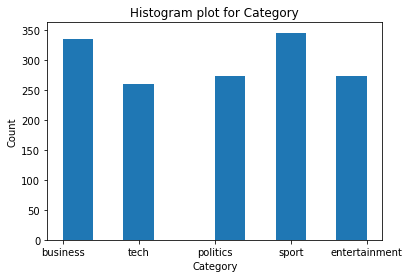

In [10]:
# Distribution for Category
plt.hist(Train_df['Category'])
plt.title('Histogram plot for Category')
plt.xlabel('Category')
plt.ylabel('Count')

In [11]:
# compare different category and text
categories = Train_df['Category'].unique()
for category in categories:
    contains = Train_df.loc[Train_df['Category'] == category, 'Text'].values[0]
    print("Category = ",category)
    print("   Text: ", contains)
    print('')

Category =  business
   Text:  worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures and prac

# preprocessing

1. lowercase all the text columns

2. Remove punctuation for the text Columns

3. Apply tokenize for the text Columns

4. Remove stop words

5. Apply lemmatization for the Text Columns

6. Join the words back to string for TF_IDF


In [12]:
def preprocessing_df (df):
    df = df.str.lower()
    df = df.replace(r'[^\w\s]', '', regex=True)
    df = df.apply(word_tokenize)
    stop_words = set(stopwords.words('english'))
    df = df.apply(lambda tokens: [word for word in tokens if word not in stop_words])
    df = df.apply(lambda tokens: [WordNetLemmatizer().lemmatize(word) for word in tokens])
    df = df.apply(' '.join)

    return df

In [13]:
#preprocessing train_df
Train_df['Text'] = preprocessing_df(Train_df['Text'])

In [14]:
#preprocessing test_df
Test_df['Text'] = preprocessing_df(Test_df['Text'])

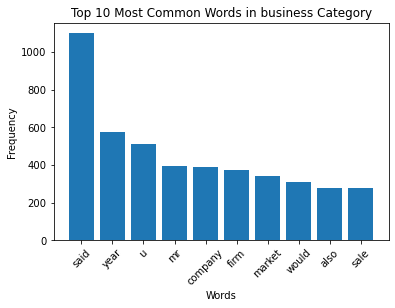

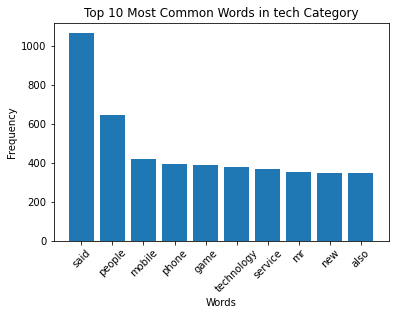

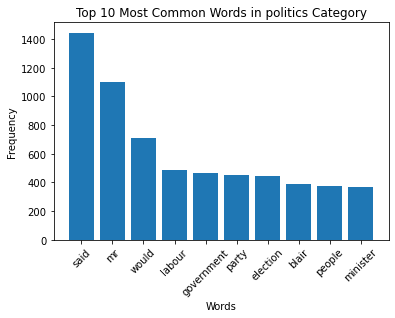

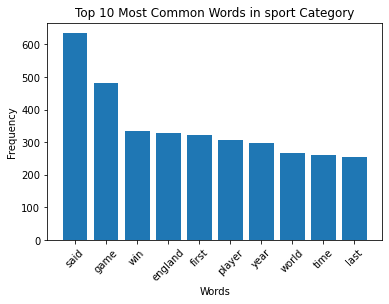

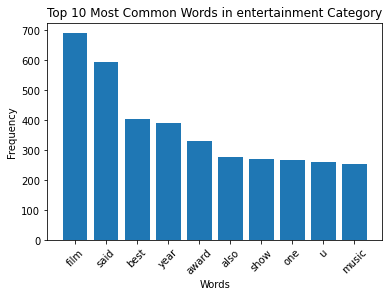

In [15]:
text = {}
for category in categories:
    all_text = ' '.join(Train_df.loc[Train_df['Category'] == category, 'Text'])
    text[category] = all_text.split()

for category, text in text.items():
    word_freq = dict(Counter(text).most_common(10))
    
    plt.bar(word_freq.keys(), word_freq.values())
    plt.title('Top {} Most Common Words in {} Category'.format(10, category))
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.show()

## TF-IDF

Explantaion:

TF calculates the term frequency of each word in each article. 

IDF calculates the frequency of each word across all the articles. 

TF-IDF together calculate the importance of each word and assign weights to each word according to the frequency. 

The output after applying the TF-IDF function is a matrix with documents and words, the values are the assigned weights.



In [16]:
vectorizer = TfidfVectorizer()
Train_tfidf = vectorizer.fit_transform(Train_df['Text'])

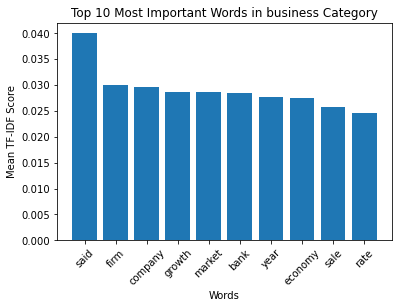

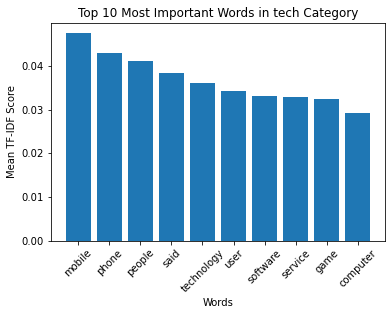

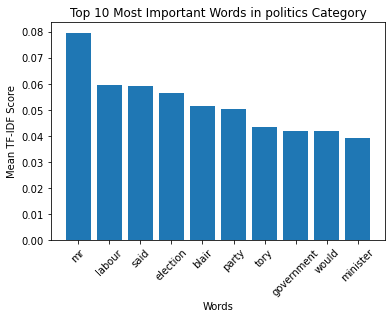

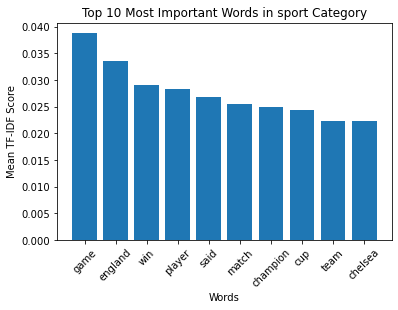

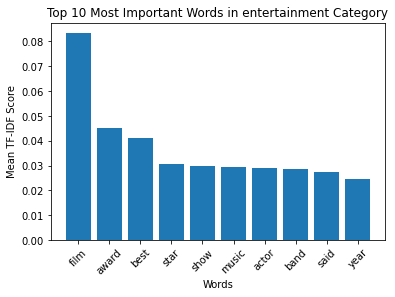

In [17]:

Train_tfidf_df = pd.DataFrame(Train_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

mean_tfidf = Train_tfidf_df.groupby(Train_df['Category']).mean()

for category in categories:
    top_words = mean_tfidf.loc[category].nlargest(10).index
    top_words_mean = mean_tfidf.loc[category, top_words]
    
    plt.bar(top_words, top_words_mean)
    plt.title('Top {} Most Important Words in {} Category'.format(10, category))
    plt.xlabel('Words')
    plt.ylabel('Mean TF-IDF Score')
    plt.xticks(rotation=45)
    plt.show()



In [18]:
Test_tfidf = vectorizer.transform(Test_df['Text'])

In [19]:
Train_tfidf.shape

(1490, 24560)

In [20]:
Test_tfidf.shape

(735, 24560)

# Non-negative matrix factorization 

1. Non-negative matrix factorization to train the data
2. Using numpy argmax to find the maximum value
3. Build a function to find the best match label for the category
4. Calculate the accuracy and confusion matrix


In [21]:
from sklearn.decomposition import NMF

nmf_model = NMF(n_components=5, random_state=42).fit(Train_tfidf)

train_w = nmf_model.transform(Train_tfidf)

# find the maximun value
yp= np.argmax(train_w, axis=1)

In [22]:
# find the best match label
def label_permute_compare(ytdf,yp,n=5):

    accuracy = 0
    
    list_1 = ['business', 'tech', 'politics', 'sport', 'entertainment']
    list_2 = [0, 1, 2, 3, 4]
    unique_combinations = []
    permut = itertools.permutations(list_1, len(list_2))
    dictd = {}
    for comb in permut:
        zipped =  dict(zip(comb, list_2))
        unique_combinations.append(zipped)
    
    for item in unique_combinations: 
        ytdf_num = ytdf['Category'].map(item)
        accu = accuracy_score(ytdf_num, yp)

        if accu > accuracy:
            accuracy = accu
            label_dict = item

    return label_dict, accuracy

In [23]:
res, accuracy = label_permute_compare(Train_df, yp, 5)
print('accuracy=', accuracy, res)

accuracy= 0.9154362416107382 {'sport': 0, 'politics': 1, 'tech': 2, 'entertainment': 3, 'business': 4}


In [24]:
label_num = Train_df['Category'].map(res)
matrix = confusion_matrix(label_num,yp)
matrix

array([[341,   0,   0,   3,   2],
       [  3, 247,   4,   0,  20],
       [  5,   3, 243,   7,   3],
       [  5,   8,  31, 222,   7],
       [  0,  14,  10,   1, 311]])

In [25]:
# predict the test data category base one the best match label
test_w = nmf_model.transform(Test_tfidf)
yp_test= np.argmax(test_w, axis=1)

# Test_df['Category'] = yp_test
# result_new = {0:'sport', 1:'politics', 2:'tech', 3:'entertainment', 4:'business'}
# Test_df['Category'] = Test_df['Category'].map(result_new)
# Final_df = Test_df[['ArticleId','Category']]
# Final_df.to_csv('final.csv', index=False)

### Test data accuracy before hyperparameter tuning is 0.91972

### Question:

#### when you train the unsupervised model for matrix factorization, should you include texts (word features) from the test dataset or not as the input matrix? Why or why not?

No, we should not include the text from the test dataset as the input martix. It will cause problem like overfitting, data leakage and miss leading accuracy.

## Hyperparameter Tuning

In [26]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('nmf', NMF())
])

param_grid = {
    'tfidf__max_features': [1000, 2000, 3000], 
    'nmf__n_components': [5],  
    'nmf__solver': ['mu'],
    'nmf__init': ['nndsvda','nndsvdar'],
    'nmf__alpha_W': [0.1, 0.01, 0.001],  
    'nmf__beta_loss': ['kullback-leibler', 'itakura-saito']  
}



grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

grid_search.fit(Train_df['Text'], Train_df['Category'])



/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 810, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 266, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 353, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 86, in _cached_call
    result, _ = _get_response_values(
  File "/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/_response.py", line 218, in _get_response_values
    

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('nmf', NMF())]),
             param_grid={'nmf__alpha_W': [0.1, 0.01, 0.001],
                         'nmf__beta_loss': ['kullback-leibler',
                                            'itakura-saito'],
                         'nmf__init': ['nndsvda', 'nndsvdar'],
                         'nmf__n_components': [5], 'nmf__solver': ['mu'],
                         'tfidf__max_features': [1000, 2000, 3000]},
             scoring='accuracy')

In [27]:
print("Best Parameters: ", grid_search.best_params_)


Best Parameters:  {'nmf__alpha_W': 0.1, 'nmf__beta_loss': 'kullback-leibler', 'nmf__init': 'nndsvda', 'nmf__n_components': 5, 'nmf__solver': 'mu', 'tfidf__max_features': 1000}


In [28]:
best_estimator = grid_search.best_estimator_
print("Best Estimator: ", best_estimator)


Best Estimator:  Pipeline(steps=[('tfidf', TfidfVectorizer(max_features=1000)),
                ('nmf',
                 NMF(alpha_W=0.1, beta_loss='kullback-leibler', init='nndsvda',
                     n_components=5, solver='mu'))])


In [29]:
# retrain the model with the best parameters

Train_tfidf = best_estimator[0].fit_transform(Train_df['Text'])

train_w = best_estimator[1].transform(Train_tfidf)

yp= np.argmax(train_w, axis=1)

res, accuracy = label_permute_compare(Train_df, yp, 5)
print('accuracy=', accuracy, res)

accuracy= 0.9355704697986578 {'politics': 0, 'sport': 1, 'entertainment': 2, 'business': 3, 'tech': 4}


In [30]:
# confusion_matrix
label_num = Train_df['Category'].map(res)
matrix = confusion_matrix(label_num,yp)
matrix

array([[267,   1,   0,   4,   2],
       [ 12, 330,   3,   1,   0],
       [ 12,   0, 257,   1,   3],
       [ 27,   1,   0, 301,   7],
       [  9,   4,   5,   4, 239]])

In [31]:
Test_tfidf = best_estimator[0].transform(Test_df['Text'])


test_w = best_estimator[1].transform(Test_tfidf)
yp_test= np.argmax(test_w, axis=1)

In [32]:
# Test_df['Category'] = yp_test
# result_new = {0:'politics', 1:'sport', 2:'entertainment', 3:'business', 4:'tech'}
# Test_df['Category'] = Test_df['Category'].map(result_new)
# Final_df = Test_df[['ArticleId','Category']]
# Final_df
# Final_df.to_csv('final2.csv', index=False)

### Test Accuracy after hyperparameter tuning is 0.93197

### Summary Table

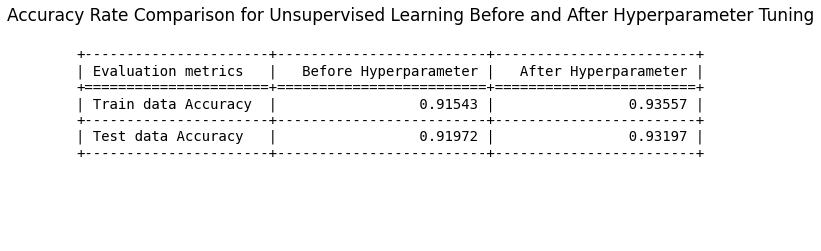

In [33]:
name = ['Train data Accuracy', 'Test data Accuracy']
before_hyper = [0.91543, 0.91972]
after_hyper = [0.93557, 0.93197]

table_data = zip(name, before_hyper, after_hyper)
table = tabulate(table_data, headers=['Evaluation metrics', 'Before Hyperparameter', 'After Hyperparameter'], tablefmt='grid')

plt.text(-0.5, 0.4, table, {'fontsize': 14, 'fontfamily': 'monospace'})
plt.axis('off')
plt.title('Accuracy Rate Comparison for Unsupervised Learning Before and After Hyperparameter Tuning', fontsize=17)
plt.show()

# Supervised learning

## 1. Train data size = 100%

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


In [35]:
clf = LogisticRegression(random_state=0).fit(Train_tfidf, Train_df['Category'])
ypredicts = clf.predict(Train_tfidf)
accuracy_score(Train_df['Category'],ypredicts)

0.9892617449664429

In [36]:
yp_test2 = clf.predict(Test_tfidf)


### Test data accuracy with 100% train data size is 0.96734


In [37]:
# Test_df['Category'] = yp_test2

# Final_df = Test_df[['ArticleId','Category']]
# Final_df
# Final_df.to_csv('SL final.csv', index=False)

## 2. Train data size = 10%

In [38]:
X_train, _, y_train, _ = train_test_split(Train_tfidf, Train_df['Category'], train_size=0.1, random_state=0)

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
ypredicts = clf.predict(X_train)
accuracy_score(y_train, ypredicts)


1.0

In [39]:
yp_test10 = clf.predict(Test_tfidf)


### Test data accuracy with 10% train data size is 0.92517

In [40]:

# Test_df['Category'] = yp_test10

# Final_df = Test_df[['ArticleId','Category']]
# Final_df.to_csv('SL final_10%.csv', index=False)

## 3. Train data size = 20%

In [41]:
X_train, _, y_train, _ = train_test_split(Train_tfidf, Train_df['Category'], train_size=0.2, random_state=0)

clf = LogisticRegression(random_state=0).fit(X_train, y_train)
ypredicts = clf.predict(X_train)
accuracy_score(y_train, ypredicts)

1.0

In [42]:
yp_test20 = clf.predict(Test_tfidf)


### Test data accuracy with 20% train data size is 0.95918

In [43]:
# Test_df['Category'] = yp_test20

# Final_df = Test_df[['ArticleId','Category']]
# Final_df.to_csv('SL final_20%.csv', index=False)

## 4. Train data size = 50%

In [44]:
X_train, _, y_train, _ = train_test_split(Train_tfidf, Train_df['Category'], train_size=0.5, random_state=0)


In [45]:
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
ypredicts = clf.predict(X_train)
accuracy_score(y_train, ypredicts)

0.9946308724832215

In [46]:
yp_test50 = clf.predict(Test_tfidf)


### Test data accuracy with 50% train data size is 0.96462


In [47]:

# Test_df['Category'] = yp_test50

# Final_df = Test_df[['ArticleId','Category']]
# Final_df.to_csv('SL final_50%.csv', index=False)

### Summary Table

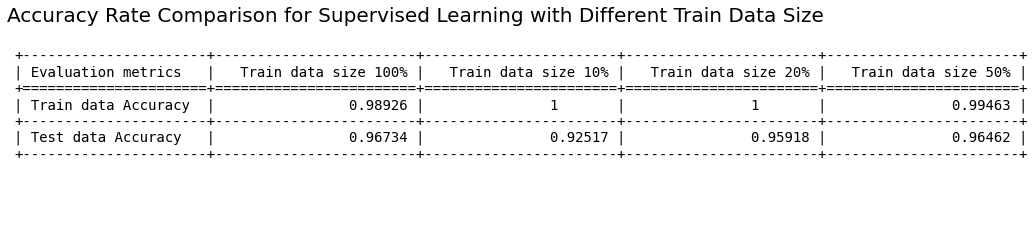

In [48]:
name = ['Train data Accuracy', 'Test data Accuracy']
size100 = [0.98926, 0.96734]
size10 = [1.0, 0.92517]
size20 = [1.0, 0.95918]
size50 = [0.99463, 0.96462]

table_data = zip(name, size100, size10,size20,size50)
table = tabulate(table_data, headers=['Evaluation metrics', 'Train data size 100%', 'Train data size 10%','Train data size 20%','Train data size 50%'], tablefmt='grid')

plt.text(-0.7, 0.4, table, {'fontsize': 14, 'fontfamily': 'monospace'})
plt.axis('off')
plt.title('Accuracy Rate Comparison for Supervised Learning with Different Train Data Size',fontsize=20)
plt.show()

### Question:

#### Discuss comparison with the unsupervised approach.  Which methods are data-efficient (require a smaller amount of data to achieve similar results)? What about overfitting?

Supervised learning with train data size 50% are data-efficient with 0.96462 accuracy rate for test data. 
Supervised learning with train data size 10% and 20% is suffer with overfitting.

Unsupervised learning accuracy rate is lower than supvervised learning expect train data size 10%.
Unsupervised learning didnot suffer for overfitting issue.

# References

1. Wellyw. (2024, February 2). Unsupervised and supervised classification. Kaggle. https://www.kaggle.com/code/wellyw/unsupervised-and-supervised-classification#Unsupervised-Learning


2. Mudadla, S. (2023, November 10). Suggested order of NLP preprocessing operations. for example reviews.csv file. Medium. https://medium.com/@sujathamudadla1213/suggested-order-of-nlp-preprocessing-operations-for-example-reviews-csv-file-06e88485ab49

3. Mattison. (2022, July 4). Unsupervised - matrix factorization. Kaggle. https://www.kaggle.com/code/mattison/unsupervised-matrix-factorization

4. GeeksforGeeks. (2024, January 3). Removing stop words with NLTK in Python. GeeksforGeeks. https://www.geeksforgeeks.org/removing-stop-words-nltk-python/

5. How to remove special characters in Pandas Dataframe | Saturn Cloud Blog. (2024, January 11). https://saturncloud.io/blog/how-to-remove-special-characters-in-pandas-dataframe/

6. Cjtayl. (2024, January 29). mini_project_part_1. Kaggle. https://www.kaggle.com/code/cjtayl31772/mini-project-part-1